In this notebook we're interested in comparing model 20 and model 23(root scaling) using the new visualizations developed in the notebooks 1 and 2.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sdo.viz.plot_vt_outputs import plot_2Dhist_95cl

In [2]:
data_inventory =  '/home/Valentina/inventory_1904.pkl'
results_path = '/fdl_sdo_data/bucket/EXPERIMENT_RESULTS/VIRTUAL_TELESCOPE/vale_exp_23/'

In [3]:
# For details about how these predictions have been calculated refer to the the notebook 
# flares/experiments/02_train_on_flares.ipynb
pred23_on23 = results_path + '0600_vale_exp_23_train_predictions.npy'

Y = np.load(pred23_on23)
shape = Y.shape
Y_test = Y[:,:,0:int(shape[2]/2),:]
Y_pred = Y[:,:,int(shape[2]/2):,:]

# root scaling has been applied to input and output in exp23. 
# In order to compare wiht exp 20 we need to scale back
Y_test = np.power(Y_test, 2)
Y_pred = np.power(Y_pred, 2)

In [4]:
Y_test = Y_test.flatten()
Y_pred = Y_pred.flatten()
idx = np.argsort(Y_test)
Y_test = Y_test[idx]
Y_pred = Y_pred[idx]

In [5]:
mask1 = Y_test > 0
Y_test = Y_test[mask1]
Y_pred = Y_pred[mask1]

In [6]:
Y_test[0], Y_pred[0]

(2.1843465e-05, 0.00034770707)

In [7]:
max(Y_test), max(Y_pred)
# NB some numerical errors affect the max, the test max should be the same as in nb2 but it is not

(26.22024, 84.95721)

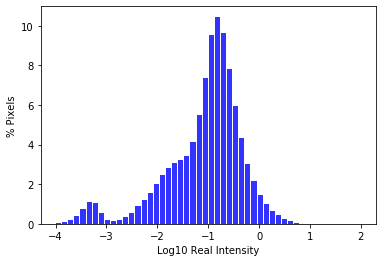

In [8]:
bins = 50
xrange = [-4,2]
width = 0.1
y, binEdges = np.histogram(np.log10(Y_test), bins=bins, range=xrange)
ynorm = y/len(Y_test)*100
bincenters = 0.5*(binEdges[1:] + binEdges[:-1])
plt.bar(bincenters, ynorm, width=width, color='b', alpha=0.8)
plt.xlabel('Log10 Real Intensity')
plt.ylabel('% Pixels')
plt.show()

the output is comparable to what we had in notebook 2, this is expected and encouraging

In [9]:
binEdges[1]

-3.88

In [10]:
# this will take several minutes
i = 0
l_bins= []
l_bincenters = []
for val in Y_test:
    if np.log10(val) <= binEdges[i+1]:
        l_bins.append(i)
    else:
        i=i+1
        l_bins.append(i)
    l_bincenters.append(bincenters[i])

In [11]:
df = pd.DataFrame({'Bins':l_bins, 'BinCenters':l_bincenters, 'YTest':Y_test,'YPred':Y_pred})
df['YTest-YPred'] = df.YTest - df.YPred
df['log10_YTest-log10_YPred'] = np.log10(df.YTest) - np.log10(df.YPred)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df['(YTest-YPred)/YTest'] = (df.YTest - df.YPred)/df.YTest*100

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
df.head(5)

,Bins,BinCenters,YTest,YPred,YTest-YPred,log10_YTest-log10_YPred,(YTest-YPred)/YTest
0,0,-3.94,0.000022,0.000348,-0.000326,-1.201892,-1491.812744
1,0,-3.94,0.000022,0.000330,-0.000309,-1.179616,-1412.223022
2,0,-3.94,0.000022,0.000359,-0.000337,-1.215607,-1542.884644
3,0,-3.94,0.000022,0.000163,-0.000141,-0.872093,-644.891541
4,0,-3.94,0.000022,0.000300,-0.000278,-1.137908,-1273.751099


### Combined plot - difference in log10scale

In [18]:
df_q = df[['BinCenters','log10_YTest-log10_YPred']].sample(frac=0.9).groupby('BinCenters').quantile([0.05, 0.5, 0.95]).unstack()
df_q = df_q.reset_index()

In [19]:
ym = df_q['log10_YTest-log10_YPred'][0.5] - df_q['log10_YTest-log10_YPred'][0.05]
yp = df_q['log10_YTest-log10_YPred'][0.95] - df_q['log10_YTest-log10_YPred'][0.5]

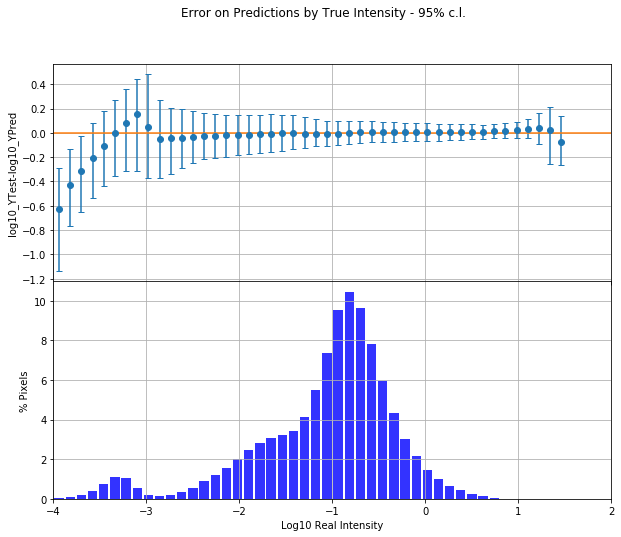

In [20]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,8))
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('Error on Predictions by True Intensity - 95% c.l.')
ax1.errorbar(df_q['BinCenters'], df_q['log10_YTest-log10_YPred'][0.5], yerr=(ym, yp), fmt='o', capsize=3)
ax1.plot([-4,2], [0,0])
ax1.set_ylabel('log10_YTest-log10_YPred')
ax2.bar(bincenters, ynorm, width=width, color='b', alpha=0.8)
ax2.set_xlabel('Log10 Real Intensity')
ax2.set_ylabel('% Pixels')
ax2.set_xlim(-4,2)
ax1.grid()
ax2.grid()

This is an order og magnitude better at low intensity (compare same plot in nb 2)

### Combined plot - relative error

In [21]:
df_q2 = df[['BinCenters','YTest', 'YTest-YPred']].groupby('BinCenters').quantile([0.05, 0.5, 0.95]).unstack()
df_q2 = df_q2.reset_index()
df_q2[:10]

BinCenters     YTest                     YTest-YPred                    
                  0.05       0.5      0.95        0.05       0.5      0.95
0      -3.94  0.000044  0.000099  0.000130   -0.000829 -0.000310 -0.000099
1      -3.82  0.000134  0.000155  0.000172   -0.000743 -0.000260 -0.000055
2      -3.70  0.000177  0.000204  0.000227   -0.000702 -0.000218 -0.000011
3      -3.58  0.000234  0.000270  0.000299   -0.000654 -0.000165  0.000045
4      -3.46  0.000308  0.000353  0.000394   -0.000611 -0.000095  0.000119
5      -3.34  0.000404  0.000460  0.000518   -0.000582 -0.000005  0.000218
6      -3.22  0.000531  0.000596  0.000680   -0.000622  0.000105  0.000347
7      -3.10  0.000698  0.000769  0.000891   -0.000844  0.000225  0.000511
8      -2.98  0.000920  0.001010  0.001177   -0.001387  0.000104  0.000692
9      -2.86  0.001220  0.001392  0.001566   -0.001888 -0.000185  0.000643

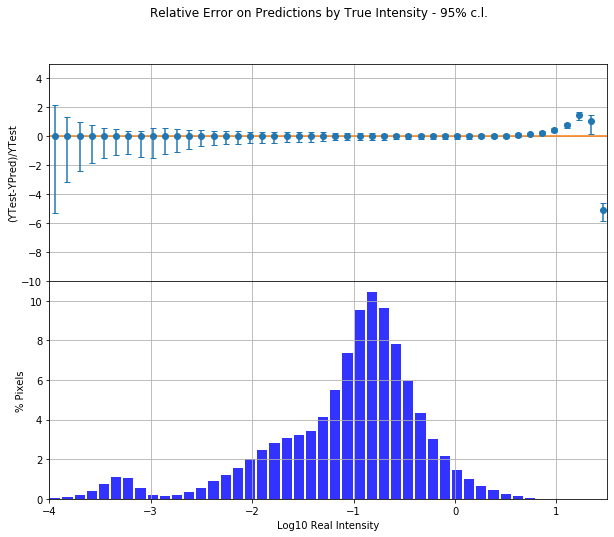

In [22]:
Y_percent =  df_q2['YTest-YPred'][0.5]/df_q2['YTest'][0.5]
ym = (df_q2['YTest-YPred'][0.5] - df_q2['YTest-YPred'][0.05])/df_q2['YTest'][0.5]
yp = (df_q2['YTest-YPred'][0.95] - df_q2['YTest-YPred'][0.5])/df_q2['YTest'][0.5]
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,8))
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('Relative Error on Predictions by True Intensity - 95% c.l.')
ax1.errorbar(df_q2['BinCenters'], 
             df_q2['YTest-YPred'][0.5], yerr=(ym, yp), fmt='o', capsize=3)
ax1.plot([-10,5], [0,0])
ax1.set_ylim(-10,5)
ax1.set_ylabel('(YTest-YPred)/YTest')
ax2.bar(bincenters, ynorm, width=width, color='b', alpha=0.8)
ax2.set_xlabel('Log10 Real Intensity')
ax2.set_ylabel('% Pixels')
ax2.set_xlim(-4,1.5)
ax1.grid()
ax2.grid()

Similar error as exp 20 at high intensity but much better at low intensity

### Absolute error

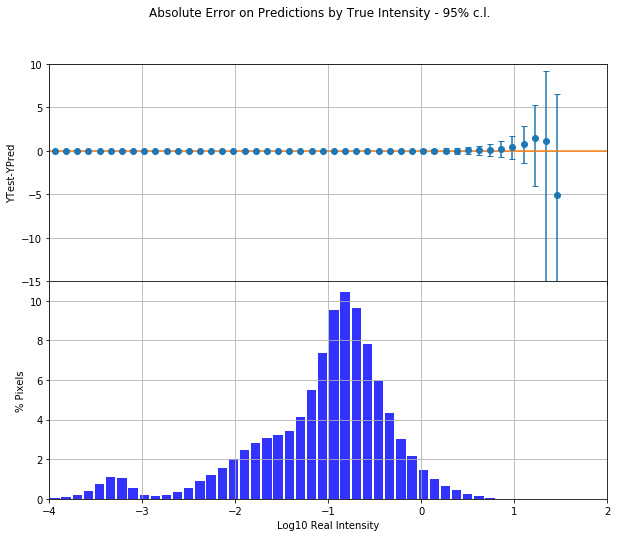

In [26]:
ym = df_q2['YTest-YPred'][0.5] - df_q2['YTest-YPred'][0.05]
yp = df_q2['YTest-YPred'][0.95] - df_q2['YTest-YPred'][0.5]
logym = np.log10(ym)
logyp = np.log10(yp)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,8))
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('Absolute Error on Predictions by True Intensity - 95% c.l.')
ax1.errorbar(df_q2['BinCenters'], 
             df_q2['YTest-YPred'][0.5], yerr=(ym, yp), fmt='o', capsize=3)
ax1.plot([-4,2], [0,0])
ax1.set_ylim(-15,10)
ax1.set_ylabel('YTest-YPred')
ax2.bar(bincenters, ynorm, width=width, color='b', alpha=0.8)
ax2.set_xlabel('Log10 Real Intensity')
ax2.set_ylabel('% Pixels')
ax2.set_xlim(-4,2)
ax1.grid()
ax2.grid()

Errors on hight intensity seems even larger when using root scaling, 
but overal absolute error comparison doesn't allow to see what happens on more relevant scales